In [1]:
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention,Embedding,Dense,Activation,Flatten,Input,BatchNormalization,Dropout,GlobalAveragePooling1D,Concatenate,MultiHeadAttention,LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.metrics import F1Score,Recall,Precision,BinaryAccuracy
from pyvi import ViTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sys
import pandas as pd 
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import max_norm
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback

2025-03-22 05:39:52.509883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-22 05:39:52.521629: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-22 05:39:52.524905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-22 05:39:52.533004: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-22 05:39:53.500856: W tensorflow/compiler/tf2

In [ ]:
import pandas as pd 
# load data
"""
    Đọc file txt 
"""
data_collum_ = np.loadtxt("collum.txt", dtype=str, delimiter=",", encoding="utf-8")
print("Name collum")
for i in range(len(data_collum_)):
    print(f"-{i}, {data_collum_[i]}")
    
df = pd.read_csv("/data/synthetic_data_0.txt", delimiter="_", header=None)
print(df.head(1))
print(df.shape)

Name collum
-0, tên người dùng
-1,  tên phim
-2,  tuổi
-3,  ngày sinh
-4,  tháng sinh
-5,  tên 10 phim đã xem gần nhất
-6,  thể loại phim
-7,  thể loại 10 phim gần nhất đã xem
-8,  thể loại xem nhiều nhất
-9,  số điểm của 10 phim đã xem
-10,  điểm của phim
-11,  mô tả phim
-12,  5 bình luận của phim
-13,  năm ra mắt phim
-14,  số lượng phim đã xem
-15,  mùa ra mắt
-16,  gioi tinh
-17,  nhãn
      0           1   2   3   4   \
0  Lý My  Knives Out  50   5  12   

                                                  5              6   \
0  The Departed, 21 Jump Street, Tropic Thunder, ...  Tội phạm, Hài   

                                                  7        8   \
0  Phiêu lưu, Hài, Hoạt hình, Hành động, Hoạt hìn...  Kinh dị   

                                                 9    10  \
0  8.5, 7.2, 7.0, 8.1, 8.1, 8.0, 7.8, 7.7, 8.2, 8.1  7.9   

                                                  11  \
0  Phim trinh thám hài hước về vụ án giết người v...   

                         

In [3]:
def encryption(key_word_, data_ ):
    """
        Tokenize theo từ khóa số từ tương ứng với số khóa
    """
    lookup_ = tf.keras.layers.StringLookup(output_mode="int")
    lookup_.adapt(data_)
    new_data_ = np.array(lookup_(data_)).reshape(-1,1)
    print(f"-{key_word_} trước khi mã hóa: {np.array(data_[0:3]).reshape(3)}   {key_word_} sau khi mã hóa: {new_data_[0:3].reshape(3)}")
    return new_data_
def convert_number_log(key_word_,data_):
    prite_product_ = np.log(data_.astype(np.float64)+1).reshape(-1,1)
    print(f"-{key_word_} trước khi mã hóa: {data_[0]}    {key_word_} sau khi mã hóa: {prite_product_[0]}")
    return prite_product_
def tokennize(key_word_, data_):
    """
        TOkenize theo loại mỗi loại mang một số duy nhất 
    """
    tokenized_data = [ViTokenizer.tokenize(i) for i in data_]
    tokenize_ = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n', split=" ")
    tokenize_.fit_on_texts(tokenized_data)
    new_data_ = tokenize_.texts_to_sequences(tokenized_data)
    new_data_ = np.array(pad_sequences(new_data_,padding="post",truncating="post"))
    print(f"-{key_word_} trước khi tokennize: {tokenized_data[0]}    {key_word_} sau khi tokennize: {new_data_[0]}")
    return new_data_

In [4]:
# name_user_ = tokennize("Name user",df.iloc[:,0])
name_movies_ = tokennize("Name movies",df.iloc[:,1])
age_ = np.array(df.iloc[:,2]).reshape(-1,1)
print(f"-Age: {age_[0]}")
day_user_ = np.array(df.iloc[:,3]).reshape(-1,1)
print(f"-Day user: {day_user_[0]}")
month_user_ = np.array(df.iloc[:,4]).reshape(-1,1)
print(f"-Month user: {month_user_[0]}")
name_movies_10_ = tokennize("Name movies 10",df.iloc[:,5])
type_movies_ = tokennize("Type movies",df.iloc[:,6])
type_movies_10_ = tokennize("Type movies 10",df.iloc[:,7])
type_movies_best_ = tokennize("Type movies best",df.iloc[:,8])
rate_movies_10_ = np.array([[float(j) for j in i.split(",")]for i in df.iloc[:,9]])
print(f"-Rate 10 movies: {rate_movies_10_[0]}")
rate_movies_ = np.array(df.iloc[:,10]).reshape(-1,1)
print(f"-Rate movies: {rate_movies_[0]}")
desription_ = tokennize("desription movies",df.iloc[:,11])
coment_5_movies_ = tokennize("5 coment",df.iloc[:,12])
year_ = convert_number_log("Year movies",np.array(df.iloc[:,13]))
count_movies_ = convert_number_log("Count movies",np.array(df.iloc[:,14]))
seassion_ = encryption("Seassion",df.iloc[:,15])
sex_ = np.array(df.iloc[:,16]).reshape(-1,1)
print(f"-Sex movies: {sex_[0]}")


-Name movies trước khi tokennize: Knives_Out    Name movies sau khi tokennize: [25  0  0  0  0]
-Age: [50]
-Day user: [5]
-Month user: [12]
-Name movies 10 trước khi tokennize: The_Departed , 21 Jump_Street , Tropic_Thunder , Gone_Girl , Prisoners , Pirates of the Caribbean , Kung Fu_Panda , Zodiac , Titanic , Finding_Nemo    Name movies 10 sau khi tokennize: [137  72  73 142  61 111  42   1   2  43 120 121  52 143  31   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
-Type movies trước khi tokennize: Tội_phạm , Hài    Type movies sau khi tokennize: [2 3 0 0]
-Type movies 10 trước khi tokennize: Phiêu_lưu , Hài , Hoạt_hình , Hành_động , Hoạt_hình , Phiêu_lưu , Tội_phạm , Hành_động , Tình_cảm , Phiêu_lưu , Hài , Hành_động , Tội_phạm , Trinh_thám , Hài , Chiến_tranh , Tội_phạm , Tình_cảm    Type movies 10 sau khi tokennize: [ 3  4  9  1  9  3  2  1  5  3  4  1  2 13  4 10  2  5  0  0  0  0  0  0
  0  0  0  0  0]
-Type movies best trước khi tokennize: Kinh_dị  

I0000 00:00:1742597530.566454     551 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742597530.641221     551 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742597530.641282     551 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742597530.642196     551 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742597530.642228     551 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [5]:
data_y_ = np.array(df.iloc[:,-1]).astype(np.int32)
unique, counts = np.unique(data_y_, return_counts=True)
data_x_ = np.concatenate((name_movies_,age_,day_user_,month_user_,name_movies_10_,type_movies_,type_movies_10_,type_movies_best_,rate_movies_10_,rate_movies_,desription_,coment_5_movies_,year_,count_movies_,seassion_,sex_),axis=1)
data_y_ = data_y_.reshape(-1,1)
print(data_x_.shape)
print(data_y_.shape)
print(dict(zip(unique, counts)))

(500000, 184)
(500000, 1)
{0: 233550, 1: 266450}


In [6]:
data_x1_ = np.concatenate((age_,
                           month_user_,
                           day_user_,
                           sex_),axis=1)

data_x2_ = np.concatenate((name_movies_,
                           name_movies_10_,
                           type_movies_,
                           type_movies_10_,
                           type_movies_best_,
                           year_,
                           rate_movies_,
                           seassion_),axis=1)

data_x3_ = np.concatenate((count_movies_,
                           rate_movies_10_),axis=1)

data_x4_ = desription_

data_x5_ = coment_5_movies_



# Gộp tất cả dữ liệu vào một tuple
data_x = (data_x1_, data_x2_, data_x3_, data_x4_, data_x5_)


# Shuffle tất cả dữ liệu cùng với nhãn
shuffled = shuffle(*data_x, data_y_, random_state=42)

# Giải nén dữ liệu đã shuffle
data_x1_, data_x2_, data_x3_, data_x4_, data_x5_, data_y_= shuffled

# # Kiểm tra lại shape sau khi shuffle
print(f"-Shape dữ liệu nhóm 1: {data_x1_.shape}")
print(f"-Shape dữ liệu nhóm 2: {data_x2_.shape}")
print(f"-Shape dữ liệu nhóm 3: {data_x3_.shape}")
print(f"-Shape dữ liệu nhóm 4: {data_x4_.shape}")
print(f"-Shape dữ liệu nhóm 5: {data_x5_.shape}")
print(f"-Shape nhãn: {data_y_.shape}")
print("embeding deep: ")
print(min(int(np.sqrt(np.max(data_x1_)))+1,50))
print(min(int(np.sqrt(np.max(data_x2_)))+1,50))
print(min(int(np.sqrt(np.max(data_x3_)))+1,50))
print(min(int(np.sqrt(np.max(data_x4_)))+1,50))
print(min(int(np.sqrt(np.max(data_x5_)))+1,50))
print("input dim embed")
print(np.max(data_x1_))
print(np.max(data_x2_))
print(np.max(data_x3_))
print(np.max(data_x4_))
print(np.max(data_x5_))

-Shape dữ liệu nhóm 1: (500000, 4)
-Shape dữ liệu nhóm 2: (500000, 77)
-Shape dữ liệu nhóm 3: (500000, 11)
-Shape dữ liệu nhóm 4: (500000, 17)
-Shape dữ liệu nhóm 5: (500000, 75)
-Shape nhãn: (500000, 1)
embeding deep: 
9
13
4
21
36
input dim embed
70
152.0
9.0
413
1278


In [7]:
from tensorflow.keras.utils import register_keras_serializable

# @register_keras_serializable
class PositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model,name_,trainable=True,dtype="float32"):
        super().__init__(name=name_,trainable=trainable,dtype=dtype)
        self.pos_emb = self.add_weight(
            shape=(sequence_length, d_model),  # Ma trận vị trí (số đặc trưng x d_model)
            initializer="random_normal",
            trainable=True,
            name="position_embedding"
        )

    def call(self, inputs, training=True):
        return inputs + self.pos_emb  # Cộng thẳng vào embedding    

# @register_keras_serializable
class encode(tf.keras.layers.Layer):
    def __init__(self, deep_, num_head_, dropout_rate_, name_,trainable=True,dtype="float32"):
        super(encode, self).__init__(name=name_,trainable=trainable,dtype=dtype)
        self.attention_ = MultiHeadAttention(num_heads = num_head_, key_dim = deep_)
        self.dense_ = Dense(deep_,kernel_regularizer = regularizers.l2(0.001),kernel_constraint=max_norm(3), activation='relu')
        self.l1_ = LayerNormalization(epsilon=1e-6)
        self.dr1_ = Dropout(dropout_rate_)
        self.l2_ = LayerNormalization(epsilon=1e-6)
        self.dr2_ = Dropout(dropout_rate_)

    def call(self, input, training=True):
        x1_ = self.attention_(input[0],input[0])
        # x2_ = self.dr1_(x1_)
        x3_ = self.l1_(x1_+input[1])

        x4_ = self.dense_(x3_)
        # x5_ = self.dr2_(x4_)
        x6_ = self.l2_(x4_+x3_)

        return x6_

# @register_keras_serializable
class emded(tf.keras.layers.Layer):
    def __init__(self, data_x1_, data_x2_, data_x3_, data_x4_, data_x5_, name_, deep_,trainable=True,dtype="float32"):
        super(emded, self).__init__(name=name_,trainable=trainable,dtype=dtype)
        self.input_dims = [int(np.max(data_x1_)+1), int(np.max(data_x2_)+1), 
                           int(np.max(data_x3_)+1), int(np.max(data_x4_)+1), 
                           int(np.max(data_x5_)+1)]
        self.output_dims = [min(int(np.sqrt(dim))+1, 50) for dim in self.input_dims]
        self.deep = deep_

        self.embed_layers = [Embedding(input_dim=dim, output_dim=out_dim) 
                             for dim, out_dim in zip(self.input_dims, self.output_dims)]
        self.dense_layers = [Dense(self.deep, use_bias=False) for _ in range(5)]
        self.concat_ = Concatenate(axis=1)

    def call(self, inputs, training=True):
        x1_, x2_, x3_, x4_, x5_ = inputs
        x_embedded = [embed(x) for embed, x in zip(self.embed_layers, [x1_, x2_, x3_, x4_, x5_])]
        x_dense = [dense(x) for dense, x in zip(self.dense_layers, x_embedded)]
        return self.concat_(x_dense)

    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dims": self.input_dims,
            "output_dims": self.output_dims,
            "deep": self.deep
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Khởi tạo object với các giá trị mặc định hợp lý
        return cls(
            data_x1_=np.zeros(config["input_dims"][0]-1),  
            data_x2_=np.zeros(config["input_dims"][1]-1),
            data_x3_=np.zeros(config["input_dims"][2]-1),
            data_x4_=np.zeros(config["input_dims"][3]-1),
            data_x5_=np.zeros(config["input_dims"][4]-1),
            name_="restored_emded",
            deep_=config["deep"]
        )
        
# @register_keras_serializable 
class output(tf.keras.layers.Layer):
    def __init__(self, dropout_rate, deep_, name_,trainable=True,dtype="float32"):
        super(output, self).__init__(name=name_,trainable=trainable,dtype=dtype)
        self.dense_out1_ = Dense(deep_)
        self.l_out1_ = LayerNormalization(epsilon=1e-6)
        self.d_out1_ = Dropout(0.2)

    def call(self, input, training=True):
        x_ = self.dense_out1_(input)
        x_ = self.l_out1_(x_)
        x_ = self.d_out1_(x_)
        
        return x_


In [8]:
input1_ = Input(shape=(len(data_x1_[0]),))
input2_ = Input(shape=(len(data_x2_[0]),))
input3_ = Input(shape=(len(data_x3_[0]),))
input4_ = Input(shape=(len(data_x4_[0]),))
input5_ = Input(shape=(len(data_x5_[0]),))


# embed1_ = Embedding(input_dim=int(np.max(data_x1_)+1), output_dim=min(int(np.sqrt(np.max(data_x1_)))+1,50), name="embedding_1")(input1_)
# embed2_ = Embedding(input_dim=int(np.max(data_x2_)+1), output_dim=min(int(np.sqrt(np.max(data_x2_)))+1,50), name="embedding_2")(input2_)
# embed3_ = Embedding(input_dim=int(np.max(data_x3_)+1), output_dim=min(int(np.sqrt(np.max(data_x3_)))+1,50), name="embedding_3")(input3_)
# embed4_ = Embedding(input_dim=int(np.max(data_x4_)+1), output_dim=min(int(np.sqrt(np.max(data_x4_)))+1,50), name="embedding_4")(input4_)
# embed5_ = Embedding(input_dim=int(np.max(data_x5_)+1), output_dim=min(int(np.sqrt(np.max(data_x5_)))+1,50), name="embedding_5")(input5_)

# embed_full_ = project_embedding([embed1_,embed2_,embed3_,embed4_,embed5_],256)

emded_ = emded(data_x1_, data_x2_, data_x3_, data_x4_, data_x5_, "embeding", 256)([input1_,input2_,input3_,input4_,input5_])

pos_ = PositionEmbedding(sequence_length=emded_.shape[1], d_model = 256,name_ = "pos_1")(emded_)

encode1_ = encode(deep_ = 256, num_head_ = 2, dropout_rate_ = 0.2, name_="encode_1")([pos_,pos_])

flatten_ = GlobalAveragePooling1D(name="flatten_1")(encode1_)

out1_ = output(dropout_rate = 0.2, deep_ = 256, name_ = "ffn_output_1")(flatten_)

out_full_ = Dense(1,activity_regularizer = regularizers.l2(0.0001),activation='sigmoid',name="output")(out1_)

model_ = Model([input1_,input2_,input3_,input4_,input5_],out_full_,name="test_model")
model_.summary()

Model: "test_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 77)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 75)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeding (emded)    │ (None, 184, 256)  │     78,654 │ input_layer[0][0… │
│                     │                   │            │ input_layer_1[0]… │
│                     │                   │            │ input_layer_2[0]… │
│                     │                   │            │ input_layer_3[0]… │
│                     │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pos_1               │ (None, 184, 256)  │     47,104 │ embeding[0][0]    │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encode_1 (encode)   │ (None, 184, 256)  │    592,896 │ pos_1[0][0],      │
│                     │                   │            │ pos_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1           │ (None, 256)       │          0 │ encode_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_output_1        │ (None, 256)       │     66,304 │ flatten_1[0][0]   │
│ (output)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        257 │ ffn_output_1[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 785,215 (3.00 MB)

 Trainable params: 785,215 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
threshold_ = 0.6

opt = tf.keras.optimizers.Adam(learning_rate=1e-4,clipnorm=1.0)
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", threshold=threshold_, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name="tp", initializer="zeros")
        self.false_positives = self.add_weight(name="fp", initializer="zeros")
        self.false_negatives = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)  # Chuyển xác suất thành nhãn 0-1
        y_true = tf.cast(y_true, tf.float32)

        tp = tf.reduce_sum(y_true * y_pred)  # True Positives
        fp = tf.reduce_sum((1 - y_true) * y_pred)  # False Positives
        fn = tf.reduce_sum(y_true * (1 - y_pred))  # False Negatives

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)
    
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [10]:
model_.compile(optimizer=opt,loss=loss,metrics=[F1Score(),BinaryAccuracy(),Recall(),Precision()])

In [11]:
"""
    Tối ưu hóa dataset
    Giảm ram khi training
"""
# chuyển mảng numpy thành dataset
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(((data_x1_,data_x2_,data_x3_,data_x4_,data_x5_), data_y_))
# Tính số lượng mẫu cho mỗi tập
total_samples = 500000
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size
# Chia dataset
train_ds = dataset.take(train_size).batch(batch_size).shuffle(1000, seed=42).prefetch(tf.data.AUTOTUNE)
val_ds = dataset.skip(train_size).take(val_size).batch(batch_size).shuffle(1000, seed=42).prefetch(tf.data.AUTOTUNE)
test_ds = dataset.skip(train_size + val_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

del data_x_,data_x1_,data_x2_,data_x3_,data_x4_,data_x5_,data_y_
import gc
gc.collect()  # Giải phóng bộ nhớ

1989

In [18]:
h_ = model_.fit(
    train_ds,
    epochs = 60,
    validation_data = val_ds
)   

Epoch 1/60


/home/lymi/miniconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1', 'keras_tensor_2', 'keras_tensor_3', 'keras_tensor_4']. Received: the structure of inputs=('*', '*', '*', '*', '*')
  warnings.warn(
I0000 00:00:1742597816.720800     693 service.cc:146] XLA service 0x7f98b8006ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742597816.720837     693 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-03-22 05:56:56.828375: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-22 05:56:57.428397: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-03-22 05:56:58.973769: I external/local_xla/xla/stream_executo

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.7591 - f1_score: 0.7409 - loss: 0.6782 - precision: 0.7642 - recall: 0.7959

2025-03-22 05:59:02.803122: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13', 16 bytes spill stores, 16 bytes spill loads

2025-03-22 05:59:03.045062: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14', 576 bytes spill stores, 384 bytes spill loads

2025-03-22 05:59:03.055777: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13', 1412 bytes spill stores, 1652 bytes spill loads

2025-03-22 05:59:03.632224: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14', 4 bytes spill stores, 4 bytes spill loads

2025-03-22 05:59:04.071083: I external/local_xla/xla/stream_exec

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 134s 9ms/step - binary_accuracy: 0.7591 - f1_score: 0.7409 - loss: 0.6782 - precision: 0.7642 - recall: 0.7959 - val_binary_accuracy: 0.8315 - val_f1_score: 0.7985 - val_loss: 0.4727 - val_precision: 0.9023 - val_recall: 0.7661
Epoch 2/60
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 111s 9ms/step - binary_accuracy: 0.8408 - f1_score: 0.8368 - loss: 0.4521 - precision: 0.8549 - recall: 0.8454 - val_binary_accuracy: 0.8533 - val_f1_score: 0.8599 - val_loss: 0.4288 - val_precision: 0.8482 - val_recall: 0.8820
Epoch 3/60
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 111s 9ms/step - binary_accuracy: 0.8521 - f1_score: 0.8512 - loss: 0.4286 - precision: 0.8663 - recall: 0.8554 - val_binary_accuracy: 0.8599 - val_f1_score: 0.8573 - val_loss: 0.4176 - val_precision: 0.8758 - val_recall: 0.8583
Epoch 4/60
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 110s 9ms/step - binary_accuracy: 0.8561 - f1_score: 0.8552 - loss: 0.4226 - precision: 0.8701 - recall: 0.8589 - val_binary_accuracy: 0.8633 - val_f1_s

In [19]:
model_.save_weights("model_weights.weights.h5")

2025-03-22 07:47:20.830362: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/lymi/miniconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1', 'keras_tensor_2', 'keras_tensor_3', 'keras_tensor_4']. Received: the structure of inputs=('*', '*', '*', '*', '*')
  warnings.warn(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


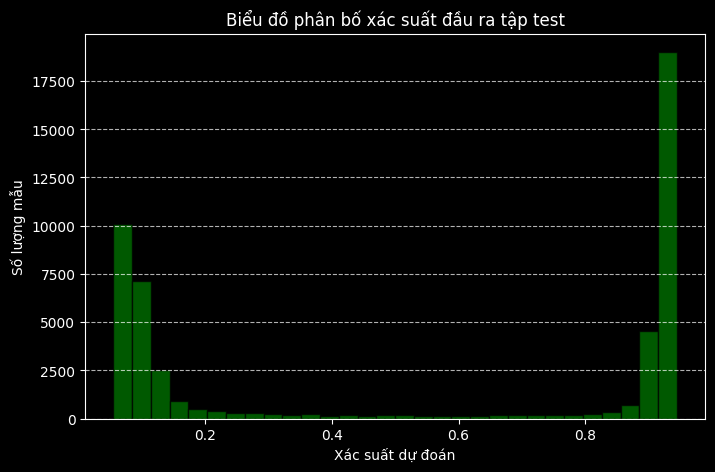

2025-03-22 07:47:30.335470: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step


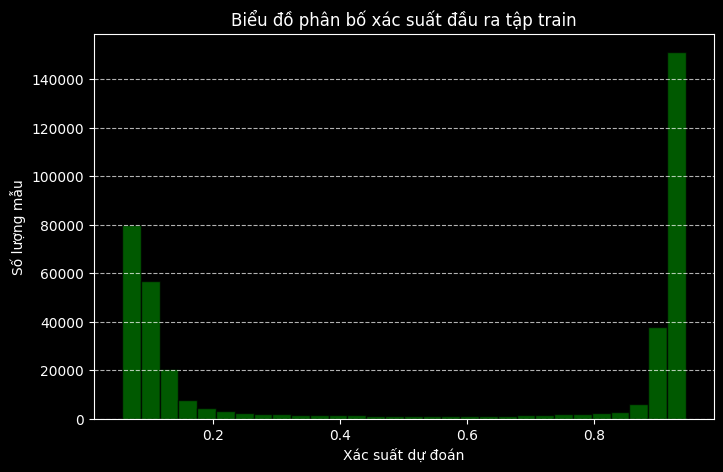

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


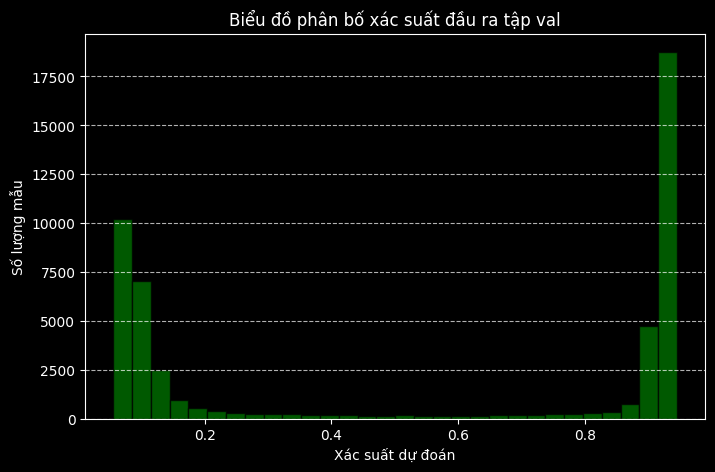

In [20]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")


def draw(x_test,key):
    y_pred_test_ = model_.predict(x_test)
    plt.figure(figsize=(8, 5))
    plt.hist(y_pred_test_, bins=30, alpha=0.7, color='green', edgecolor='black')
    plt.xlabel('Xác suất dự đoán')
    plt.ylabel('Số lượng mẫu')
    plt.title('Biểu đồ phân bố xác suất đầu ra tập '+key)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    return y_pred_test_

x_test = []
for batch in test_ds:
    x_test.append([x.numpy() for x in batch[0]])  # Convert từng batch thành numpy
# Ghép các batch lại
x_test = [np.concatenate(feature, axis=0) for feature in zip(*x_test)]
y_pred_test_ = draw(x_test,"test")


x_test = []
for batch in train_ds:
    x_test.append([x.numpy() for x in batch[0]])  # Convert từng batch thành numpy
# Ghép các batch lại
x_test = [np.concatenate(feature, axis=0) for feature in zip(*x_test)]
y_pred_train_ = draw(x_test,"train")


x_test = []
for batch in val_ds:
    x_test.append([x.numpy() for x in batch[0]])  # Convert từng batch thành numpy
# Ghép các batch lại
x_test = [np.concatenate(feature, axis=0) for feature in zip(*x_test)]
y_pred_val_ = draw(x_test,"val")


2025-03-22 07:48:06.519721: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


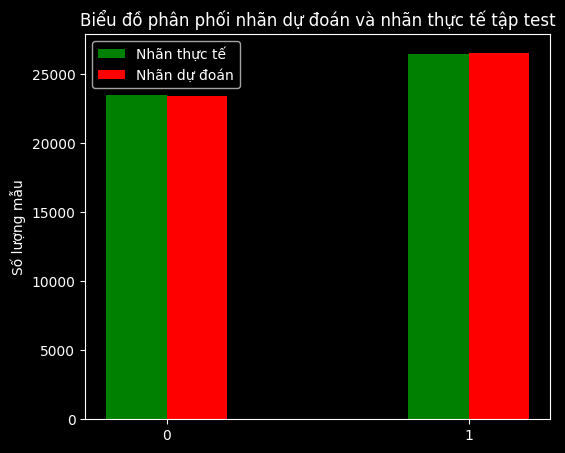

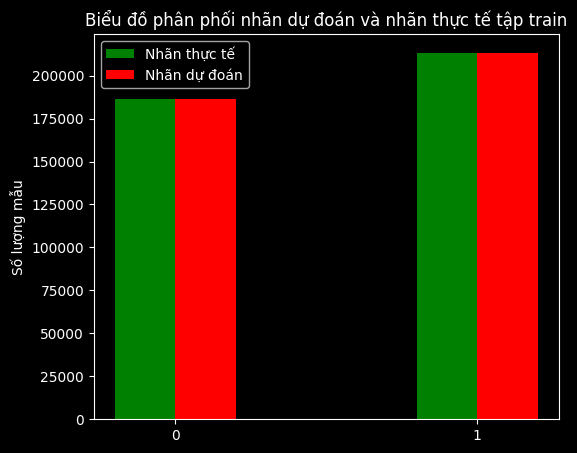

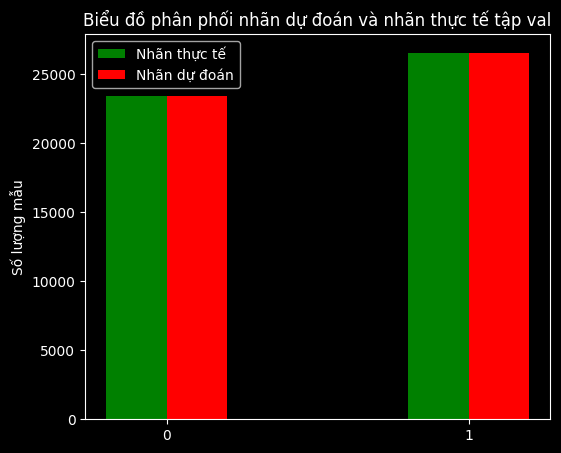

In [21]:
threshold_ = 0.5
def draw_(data_y_,y_pred, key):
    # Đếm số lượng nhãn thực tế
    true_counts = [np.sum(data_y_ == 0), np.sum(data_y_ == 1)]
    # Chuyển y_pred thành dạng nhãn nhị phân
    a = (y_pred > threshold_).astype(int)
    
    # Đếm số lượng nhãn dự đoán
    pred_counts = [np.sum(a == 0), np.sum(a == 1)]
    
    # Vẽ biểu đồ cột
    labels = ['0', '1']
    x = np.arange(len(labels))
    width = 0.2  # Độ rộng của cột
    
    plt.figure(figsize=(6, 5))
    plt.bar(x - width/2, true_counts, width, label="Nhãn thực tế", color="green", alpha=1)
    plt.bar(x + width/2, pred_counts, width, label="Nhãn dự đoán", color="red", alpha=1)
    
    # Gán nhãn
    plt.xticks(x, labels)
    plt.ylabel("Số lượng mẫu")
    plt.title("Biểu đồ phân phối nhãn dự đoán và nhãn thực tế tập "+key)
    plt.legend()
    plt.show()


# Convert data_y_ từ test_ds sang numpy array
data_y_ = []
for batch in test_ds:
    data_y_.append(batch[1].numpy())  # Convert từng batch thành numpy
# Ghép tất cả các batch lại thành numpy array
data_y_ = np.concatenate(data_y_).flatten()  # Flatten để tránh lỗi shape
draw_(data_y_,y_pred_test_, "test")

# Convert data_y_ từ test_ds sang numpy array
data_y_ = []
for batch in train_ds:
    data_y_.append(batch[1].numpy())  # Convert từng batch thành numpy
# Ghép tất cả các batch lại thành numpy array
data_y_ = np.concatenate(data_y_).flatten()  # Flatten để tránh lỗi shape
draw_(data_y_,y_pred_train_, "train")

# Convert data_y_ từ test_ds sang numpy array
data_y_ = []
for batch in val_ds:
    data_y_.append(batch[1].numpy())  # Convert từng batch thành numpy
# Ghép tất cả các batch lại thành numpy array
data_y_ = np.concatenate(data_y_).flatten()  # Flatten để tránh lỗi shape
draw_(data_y_,y_pred_val_, "val")

2025-03-22 07:51:41.547125: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


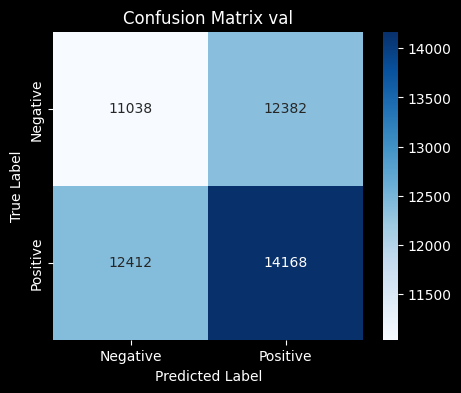

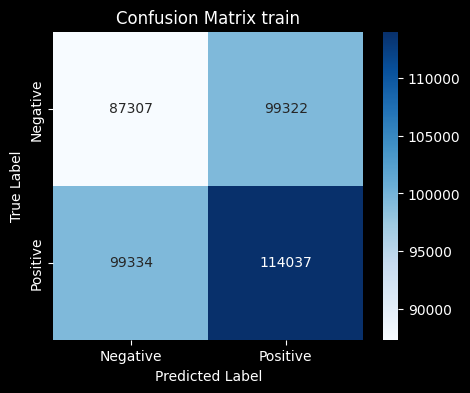

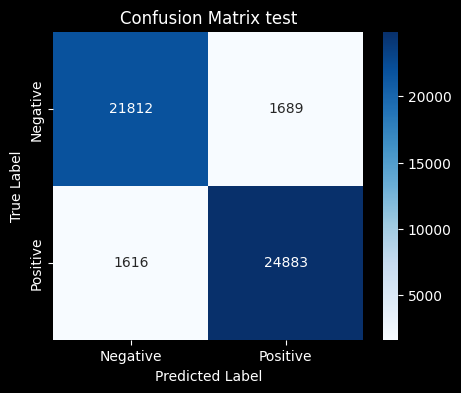

In [27]:
def plot_confusion_matrix(y_true, y_pred, threshold,key):
    """
    Vẽ confusion matrix cho bài toán phân loại nhị phân.
    
    - y_true: Nhãn thật (list hoặc numpy array)
    - y_pred: Xác suất dự đoán (list hoặc numpy array)
    - threshold: Ngưỡng để chuyển đổi xác suất thành nhãn (mặc định 0.5)
    """
    # Chuyển đổi xác suất thành nhãn nhị phân
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    # Tính Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    
    # Vẽ heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix "+key)
    plt.show()
# plot_confusion_matrix(data_y_,y_pred)

# Convert data_y_ từ test_ds sang numpy array
data_y_ = []
for batch in val_ds:
    data_y_.append(batch[1].numpy())  # Convert từng batch thành numpy
# Ghép tất cả các batch lại thành numpy array
data_y_ = np.concatenate(data_y_).flatten()  # Flatten để tránh lỗi shape
plot_confusion_matrix(data_y_,y_pred_val_,0.5, "val")
data_y_ = []
for batch in train_ds:
    data_y_.append(batch[1].numpy())  # Convert từng batch thành numpy
# Ghép tất cả các batch lại thành numpy array
data_y_ = np.concatenate(data_y_).flatten()  # Flatten để tránh lỗi shape
plot_confusion_matrix(data_y_,y_pred_train_,0.5, "train")
data_y_ = []
for batch in test_ds:
    data_y_.append(batch[1].numpy())  # Convert từng batch thành numpy
# Ghép tất cả các batch lại thành numpy array
data_y_ = np.concatenate(data_y_).flatten()  # Flatten để tránh lỗi shape
plot_confusion_matrix(data_y_,y_pred_test_,0.5, "test")

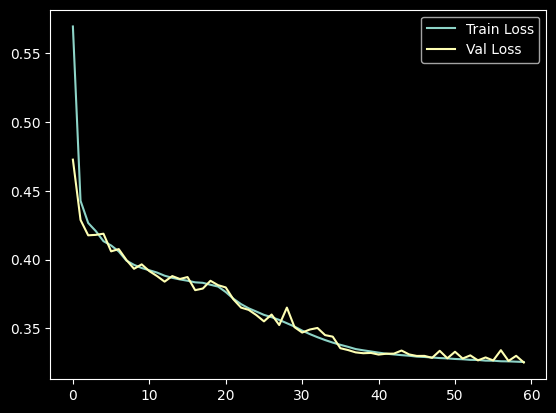

In [28]:
plt.plot(h_.history['loss'], label='Train Loss')
plt.plot(h_.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

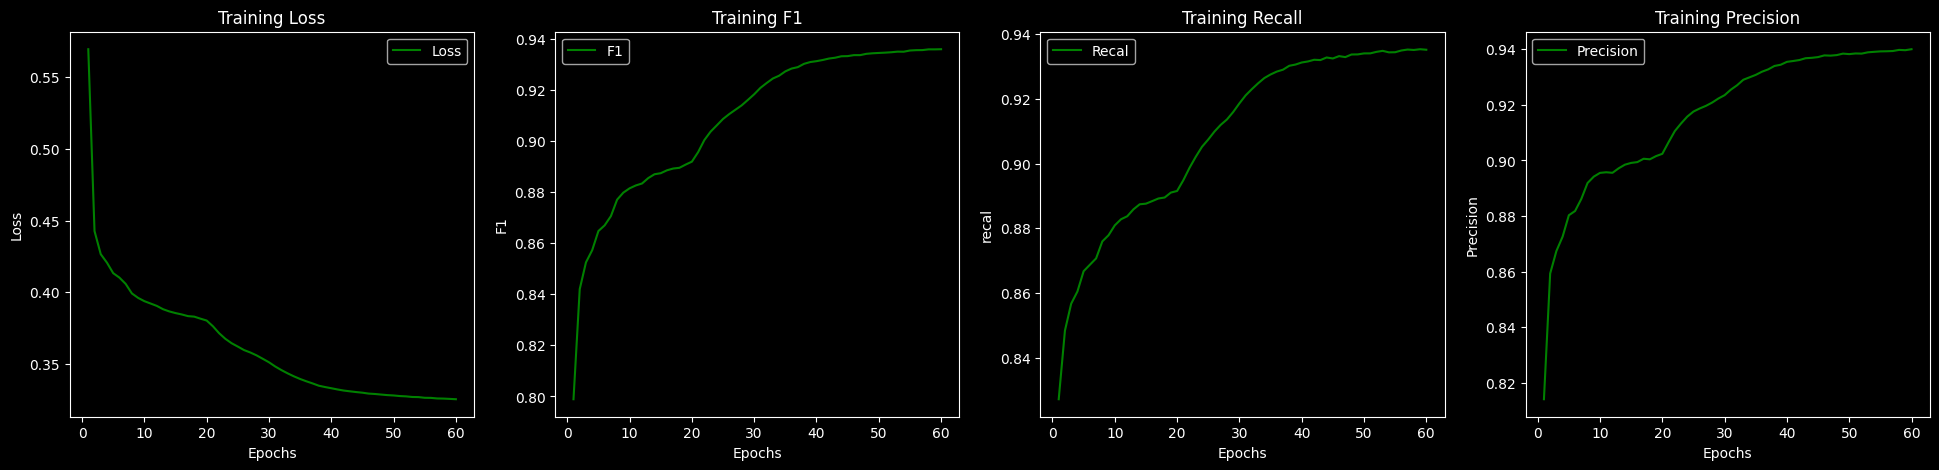

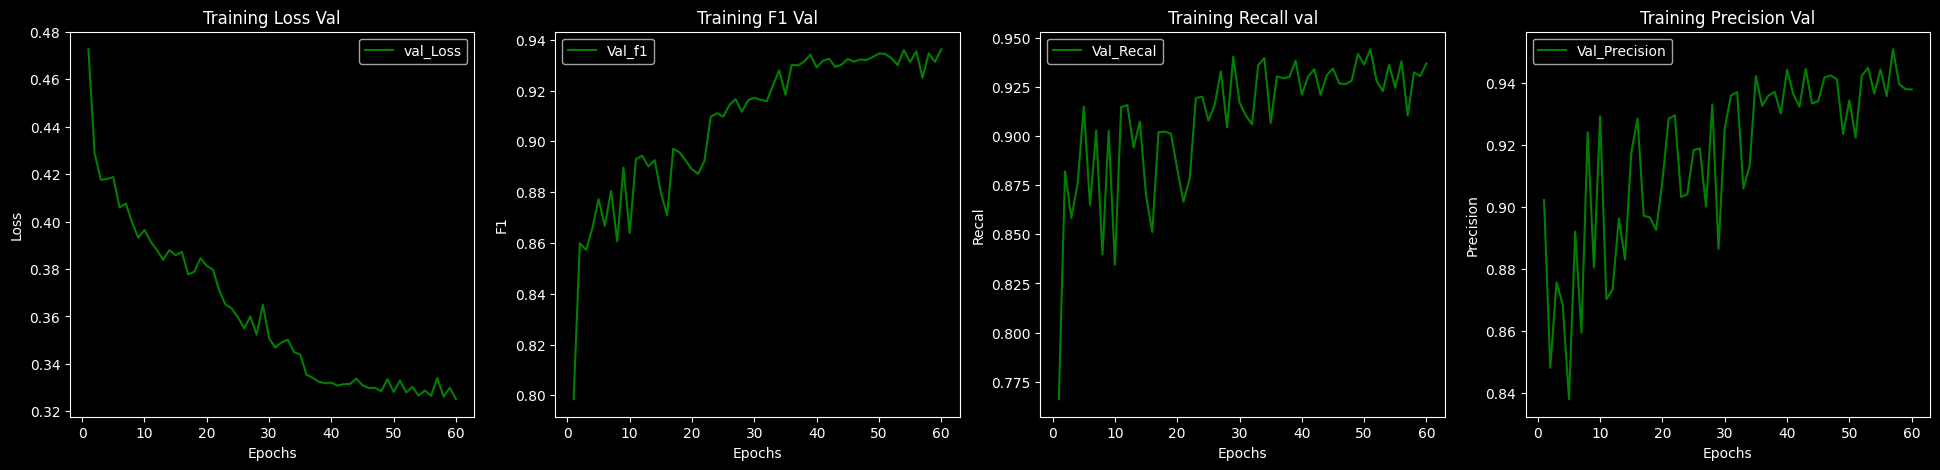

In [29]:

def plot_history(history):
    # Trích xuất dữ liệu từ history
    loss = history.history['loss']
    loss_val_ = history.history['val_loss']
    f1_ = history.history['f1_score']
    val_f1_score_ = history.history['val_f1_score']
    val_recall_ = history.history['val_recall']
    recall_ = history.history['recall']
    val_precision_ = history.history['val_precision']
    precision_ = history.history['precision']

    
    epochs = range(1, len(loss) + 1)

    # Vẽ loss
    plt.figure(figsize=(24, 5))

    plt.subplot(1, 4, 1)
    plt.plot(epochs, loss, 'green', label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    
    plt.subplot(1, 4, 2)
    plt.plot(epochs, f1_, 'green', label='F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1')
    plt.title('Training F1')
    plt.legend()
   
    plt.subplot(1, 4, 3)
    plt.plot(epochs, recall_, 'green', label='Recal')
    plt.xlabel('Epochs')
    plt.ylabel('recal')
    plt.title('Training Recall')
    plt.legend()
   
    plt.subplot(1, 4, 4)
    plt.plot(epochs, precision_, 'green', label='Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training Precision')
    plt.legend()
    

    
    plt.show()

    plt.figure(figsize=(24, 5))

    plt.subplot(1, 4, 1)
    plt.plot(epochs, loss_val_, 'green', label='val_Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Val')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.plot(epochs, val_f1_score_, 'green', label='Val_f1')
    plt.xlabel('Epochs')
    plt.ylabel('F1')
    plt.title('Training F1 Val')
    plt.legend()
   
    plt.subplot(1, 4, 3)
    plt.plot(epochs, val_recall_, 'green', label='Val_Recal')
    plt.xlabel('Epochs')
    plt.ylabel('Recal')
    plt.title('Training Recall val')
    plt.legend()
   
    plt.subplot(1, 4, 4)
    plt.plot(epochs, val_precision_, 'green', label='Val_Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training Precision Val')
    plt.legend()
    
    plt.show()
plot_history(h_)